In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from utils import functions_3D as F3D
import matplotlib.pyplot as plt
plt.style.use(r'utils/mplstyle')

from matplotlib import gridspec
import quaternion

In [2]:
# nice colours to use

colorsBlue = ['#b3e5fc', '#0091ea']
colorsRed = ['#f18e86', '#e83b47']
colorsYellow = ['#fb9d32', '#fec787']
colorsPurple = ['#d69bc5' ,'#a8509f']
colorsGreyOrange = ['#c3c3c3', '#f8a834']
colors = [colorsBlue, colorsRed, colorsYellow, colorsPurple, colorsGreyOrange]

In [3]:
seed = 219
std = 0.25
maxL = 5 # l = 2, ..., maxL

np.random.seed(seed)
As = np.random.normal(0, std, (maxL + 1) ** 2 - 1 - 3) # * np.array([0, 1, 1, 0, 0])
Ps = np.random.random(len(As)) * np.pi * 2

ball = F3D.ball(maxL, As, Ps)

In [4]:
# check the curvature across the ball
ball.check_kappa(grid_point = 100)

Maximum and minimum curvatures are: 1.66 and 0.33. These will be used to set upper and lower bounds on cmaps


In [5]:
# render the ball info, to be used for draw_ball etc.
ball.make_ball(grid_point = 200, keep = True);

In [6]:
# print critical ramp angle
QStar = np.max(ball.QFact)
alphaStar = np.arctan(QStar)
print(alphaStar)

0.1387067484434942


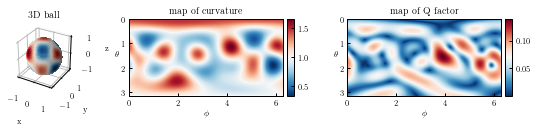

In [7]:
fig = plt.figure(figsize = (9, 2))
spec = gridspec.GridSpec(ncols=3, nrows=1, width_ratios=[1, 2.5, 2.5], wspace=0.4, hspace=0.0)
ax1 = fig.add_subplot(spec[0], projection='3d')
ax2 = fig.add_subplot(spec[1])
ax3 = fig.add_subplot(spec[2])

ball.draw_ball(ax1)
ball.draw_kappa(ax2)
ball.draw_QFact(ax3)

ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

ax2.set_xlabel(r'$\phi$')
ax2.set_ylabel(r'$\theta$', rotation = 0)
ax3.set_xlabel(r'$\phi$')
ax3.set_ylabel(r'$\theta$', rotation = 0)

plt.savefig('3DPlots/view_ball.png', dpi = 300)

In [8]:
theta_ini = np.pi / 2 + 0.3
phi_ini = np.pi * 0.5

In [9]:
ball.initialisation(THETA_CT = theta_ini, PHI_CT = phi_ini, spin = 'AUTO')

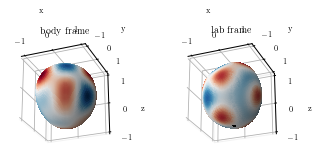

In [10]:
# plot the balls with the contact point marked with a black spot
# in the labframe plot, the mark appears at the bottom, so the initialisation is correct

fig, axes = plt.subplots(1, 2, subplot_kw={'projection': '3d'}, figsize = (5, 2))
ball.draw_initial(axes[0], axes[1])
for i in range(2):
    axes[i].view_init(elev=-25, azim=-68)
    axes[i].xaxis.pane.fill = False
    axes[i].yaxis.pane.fill = False
    axes[i].zaxis.pane.fill = False
plt.tight_layout()

In [11]:
# simulate a simple trajector 

alpha = 0.15
f = np.sin(alpha)
g = np.cos(alpha)

ball.simulate(f = f, g = g, ti = 0, tf = 100, outputN = 1000)

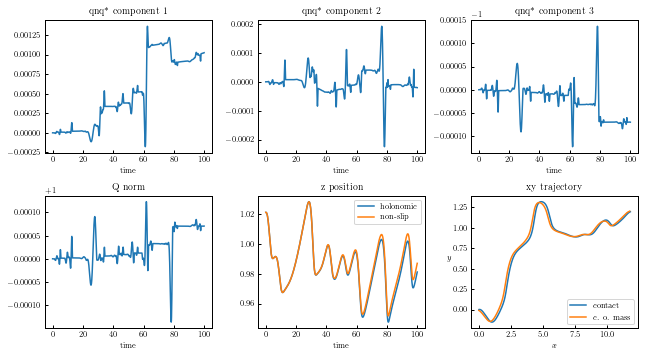

In [12]:
# quality control

# first row: we explicitly check that the lab frame normal is near (0, 0, -1)
# any error comes from numerical integration

# second row, left: check Q is unit quaternion
# second row, mid: we compute the z coordinate of C.O.M. using two methods
#                     - holonomic: obtained by rotating the contact vector to lab frame
#                     - non-slip: obtained by integrating C.O.M. over time using non-slip constraint
# second row, right: x and y positions of the contact point and C.O.M.

fig, axes = plt.subplots(2, 3, figsize = (9, 5))
axes = np.reshape(axes, -1)
ball.results_quality_control(axes)
for i in range(5):
    axes[i].set_xlabel('time')
axes[-1].set_xlabel('$x$')
axes[-1].set_ylabel('$y$', rotation = 0)
plt.legend()
plt.ticklabel_format(style='plain')
plt.tight_layout()
plt.savefig('3DPlots/sample_plot_m0/overdamped_quality_control_segment0.pdf')

In [13]:
# keep a copy of the simulation data for this segment
resA = np.copy(ball.s)
timA = np.copy(ball.t)

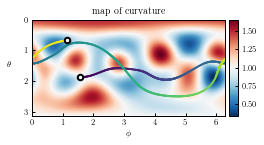

In [14]:
# visualise the motion of the contact point
# dark: early time
# light: late time

plt.figure(figsize = (4, 2))
ax = plt.axes()
ball.draw_kappa(ax)
ax.scatter(ball.s[:, 1] % (2 * np.pi), ball.s[:, 0] % (np.pi), c = ball.t, s = 1)
ax.scatter([ball.s[0, 1] % (2 * np.pi), ball.s[-1, 1] % (2 * np.pi)],
           [ball.s[0, 0] % (np.pi), ball.s[-1, 0] % (np.pi)],
           s = 30, facecolor = 'white', edgecolor = 'black', lw = 2)
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$\theta$', rotation = 0, labelpad = 15)
plt.tight_layout()
plt.savefig('3DPlots/sample_plot_m0/overdamped_contact_segment0.pdf')

In [15]:
# to continue the simulation over longer times, we need to eliminate the accumulated integration error
# this is done by keeping the contact position the same
# and adjusting the quaternion Q such that the normal is exactly (0, 0, -1) and |Q| = 1

# first take the quaternion that rotates the ball to the contact point
# this qA so calculated will be off from the ideal one by a spin factor
qA = ball.compute_direct_Q(ball.get_inputs(ball.s[-1, 0], ball.s[-1, 1]))

# qB is the current quaternion
qB = np.quaternion(*ball.s[-1, 2 : 6])

# calculate the spin factor
qC0 = quaternion.as_float_array(qB * qA.conjugate())[0]
qC3 = quaternion.as_float_array(qB * qA.conjugate())[3]
if qC0 > 0:
    spin = np.arcsin(qC3) * 2    
else:
    if qC3 > 0:
        spin = (np.pi - np.arcsin(qC3)) * 2
    else:
        spin = (- np.pi - np.arcsin(qC3)) * 2
        
ball.initialisation(THETA_CT = ball.s[-1, 0], PHI_CT = ball.s[-1, 1], spin = spin)

In [16]:
# continue the simulation 
ball.simulate(f = f, g = g, ti = 0, tf = 100, outputN = 1000)

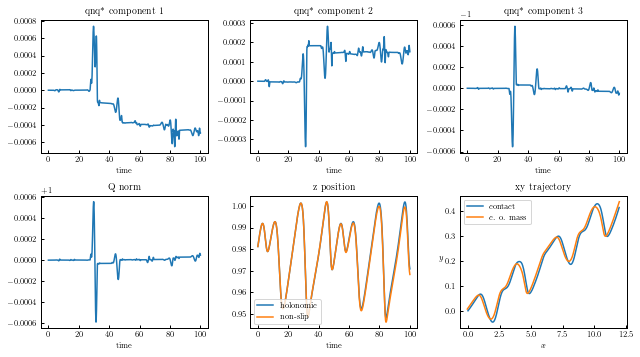

In [17]:
# quality control
fig, axes = plt.subplots(2, 3, figsize = (9, 5))
axes = np.reshape(axes, -1)
ball.results_quality_control(axes)
for i in range(5):
    axes[i].set_xlabel('time')
axes[-1].set_xlabel('$x$')
axes[-1].set_ylabel('$y$', rotation = 0)
plt.legend()
plt.ticklabel_format(style='plain')
plt.tight_layout()
plt.savefig('3DPlots/sample_plot_m0/overdamped_quality_control_segment1.pdf')

In [18]:
# keep a copy of the simulation data for this segment
resB = np.copy(ball.s)
timB = np.copy(ball.t) + timA[-1]

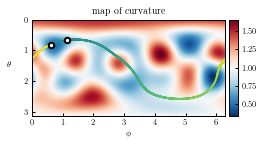

In [19]:
# visualise the motion of the contact point
# dark: early time
# light: late time
# the starting position should be the same as the end position of the last simulation segment

plt.figure(figsize = (4, 2))
ax = plt.axes()
ball.draw_kappa(ax)
ax.scatter(ball.s[:, 1] % (2 * np.pi), ball.s[:, 0] % (np.pi), c = ball.t, s = 1)
ax.scatter([ball.s[0, 1] % (2 * np.pi), ball.s[-1, 1] % (2 * np.pi)],
           [ball.s[0, 0] % (np.pi), ball.s[-1, 0] % (np.pi)],
           s = 30, facecolor = 'white', edgecolor = 'black', lw = 2)
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$\theta$', rotation = 0, labelpad = 15)
plt.tight_layout()
plt.savefig('3DPlots/sample_plot_m0/overdamped_contact_segment1.pdf')

In [20]:
# visualise quaternion motion

# first compute the vector part of the quaternion
traj = []
for i in range(len(resB)):
    _quat = np.array(resB[i, 2:6])
    if _quat[0] < 0:
        _quat *= (-1)
    traj.append(_quat[1:])
traj = np.array(traj)

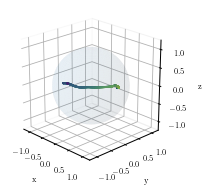

In [21]:
# then do a scatter plot of all the states
# this is the starting point for computing the Poincare map

fig = plt.figure(figsize = (5,3))
ax1 = fig.add_subplot(1,1,1, projection='3d')
ax1.view_init(elev=22, azim=-44)
ax1.set_box_aspect((1,1,1))
ax1.scatter(traj[:,0],traj[:,1],traj[:,2], s = 1, alpha = 1, c = timB)

# unit ball
X = np.sin(ball.THETA) * np.cos(ball.PHI)
Y = np.sin(ball.THETA) * np.sin(ball.PHI)
Z = np.cos(ball.THETA)
ax1.plot_surface(X, Y, Z, alpha = 0.05)

ax1.set_xlim(-1.2,1.2)
ax1.set_ylim(-1.2,1.2)
ax1.set_zlim(-1.2,1.2)

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')

ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

plt.savefig('3DPlots/sample_plot_m0/overdamped_quaternion.pdf')

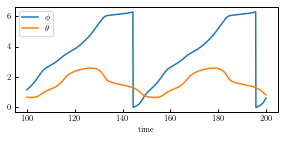

In [22]:
# plot θ and φ over time to reveal periodic behaviour
# this is the starting point for computing the period
# alternatively, you can also jsut plot the real part of the quaternion (ball.s[:, 2])

plt.figure(figsize = (4,2))
plt.plot(timB, resB[:, 1] % (2 * np.pi), label = r'$\phi$')
plt.plot(timB, resB[:, 0] % (np.pi), label = r'$\theta$')
plt.legend()
plt.xlabel('time')
plt.tight_layout()
plt.savefig('3DPlots/sample_plot_m0/overdamped_angles.pdf')